In [2]:
"""
@author: albertigno

"""

from MyDataset import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

/Users/alberto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running on: cpu


In [4]:
thresh = 0.3
batch_size = 256 # default 256
learning_rate = 1e-4 # default 1e-4
time_window = 50 # shd 50, nmnist 25-30
dataset_path = r'./../../datasets'

In [3]:
train_path = dataset_path+'/shd_digits/shd_train.h5'
test_path = dataset_path+'/shd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)
print("loading training set...")
train_dataset = MyDataset(train_path, 'hd_digits', time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [5]:
from snn_models_monitor import *
%load_ext autoreload
%autoreload 1
%aimport snn_models_monitor

tau_m = 'adp'
#tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn = RSNN_monitor('shd', num_hidden=64, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN_monitor(
  (fc_ih): Linear(in_features=700, out_features=64, bias=False)
  (fc_hh): Linear(in_features=64, out_features=64, bias=False)
  (fc_ho): Linear(in_features=64, out_features=20, bias=False)
)

In [5]:
# training configuration

num_epochs = 1
modelname = 'shd_rnn_{}_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn.fc_ih.weight,
               snn.fc_hh.weight,
               snn.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

tau_m_h 
shd_rnn_64_adp.t7


In [6]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch + 1) % 5 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        snn.save_model(modelname)   

Epoch [1/1]
Step [10/31], Loss: 0.49365
Step [20/31], Loss: 0.48160
Step [30/31], Loss: 0.47902
Time elasped: 3.7628328800201416


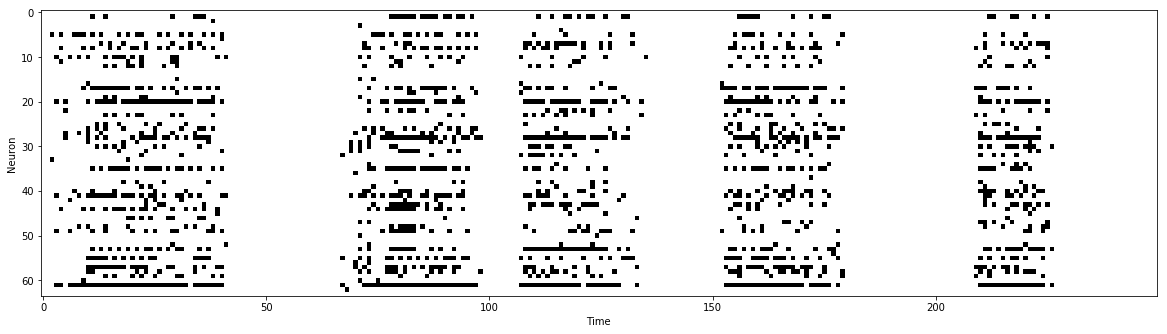

In [7]:
fig = snn.plot_activity('h','spike','normal', [0,1,2,3,4])

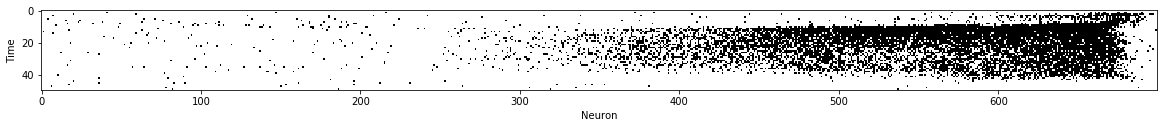

In [8]:
fig = snn.plot_activity('x','spike','normal', range(1))

[0, 1, 2]
[0, 1]
torch.Size([50, 256, 64])
torch.Size([3, 100])


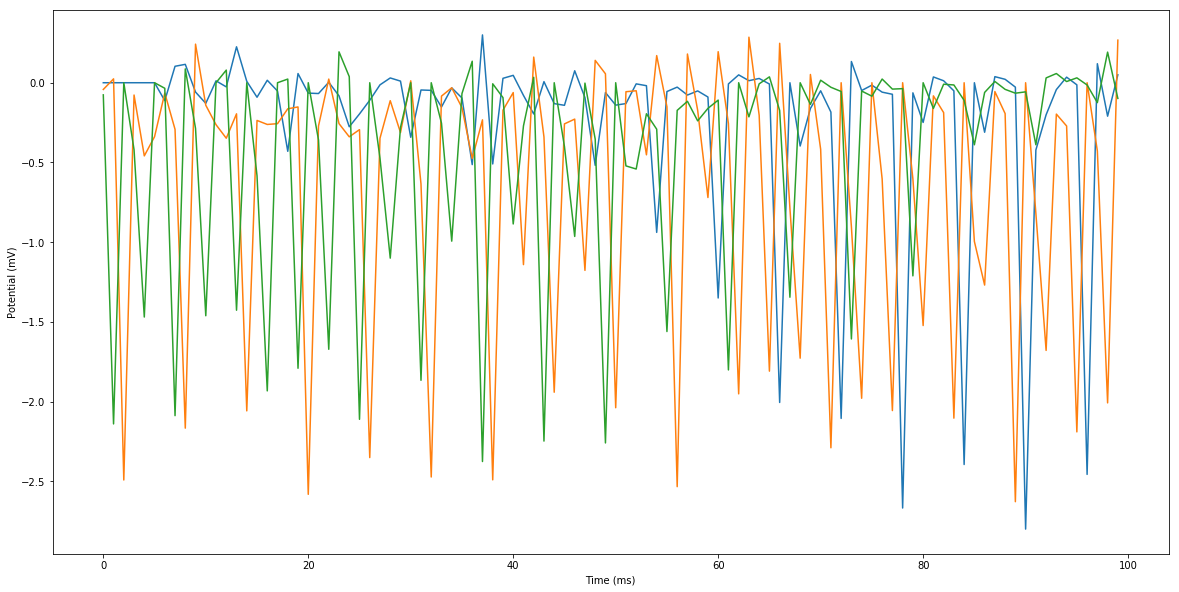

In [9]:
# neuron_id -> id of neurons to display
# sample_id -> id of sample to display
fig = snn.plot_mem('h', neuron_id =[0, 1, 2], sample_id = [0,1])

In [ ]:
snn.plot_weights('hh', 'histogram')

#### Single neuron analysis

In [33]:
from MyDataset import *

time_window = 50
batch_size = 1
#device = 'cuda:0'
device = device

dataset_path = r'./../../datasets'
test_path = dataset_path+'/shd_digits/shd_test.h5'

#test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)

test_dataset = MyDataset(path ='1_20', method= 'random', win=time_window, device=device,num_samples = None)
test_dataset.images = torch.zeros(test_dataset.images.shape)

#test_dataset.images[0, 10, 5] = 1.0
#test_dataset.images[0, 11, 5] = 1.0
test_dataset.images[0, 12, 5] = 1.0
test_dataset.images[0, 12, 6] = 1.0
test_dataset.images[0, 2, 5] = 1.0
test_dataset.images[0, 20, 5] = 1.0

num sample: 1
torch.Size([1, 50, 20]) torch.Size([1, 10])


In [34]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=False)


In [35]:
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn2 = RSNN_monitor('custom_20_10', num_hidden=10, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn2.to(device)

RSNN_monitor(
  (fc_ih): Linear(in_features=20, out_features=10, bias=False)
  (fc_hh): Linear(in_features=10, out_features=10, bias=False)
  (fc_ho): Linear(in_features=10, out_features=10, bias=False)
)

In [36]:
snn2.fc_ih.weight = torch.nn.Parameter(0.2*torch.ones(snn2.fc_ih.weight.shape, device=device))
snn2.fc_hh.weight = torch.nn.Parameter(0.0*torch.ones(snn2.fc_hh.weight.shape, device=device))
snn2.test(test_loader, criterion=nn.MSELoss())

Test Accuracy of the model on the test samples: 100.000


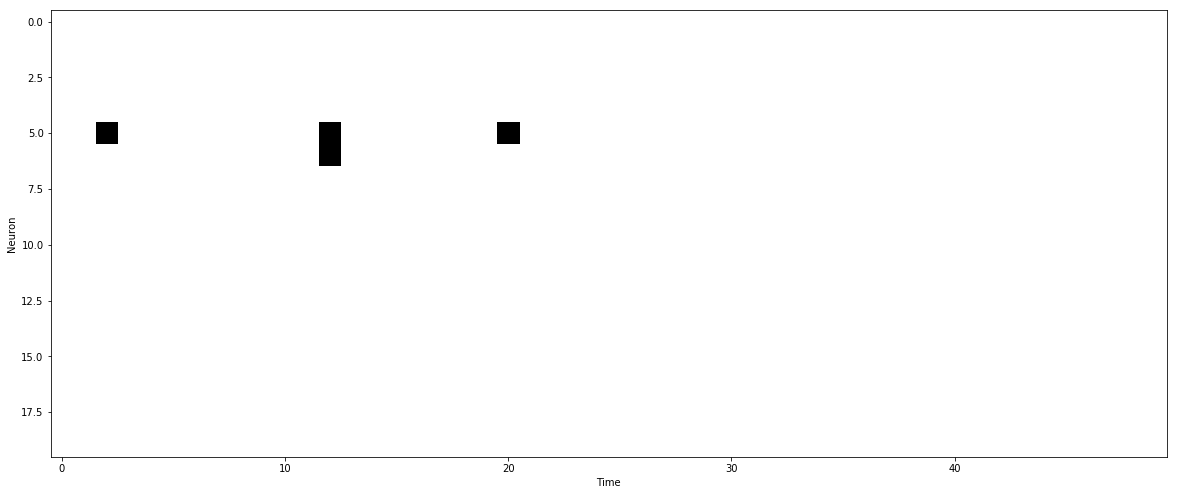

In [37]:
fig = snn2.plot_activity('x')

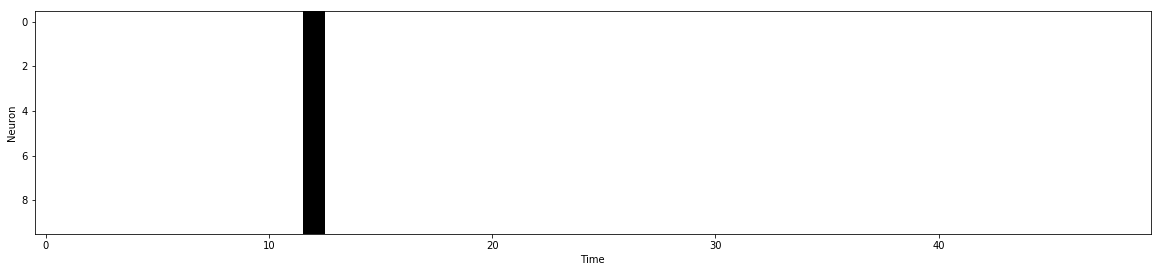

In [38]:
fig = snn2.plot_activity('h')

[0]
[0]
torch.Size([50, 1, 10])
torch.Size([1, 50])


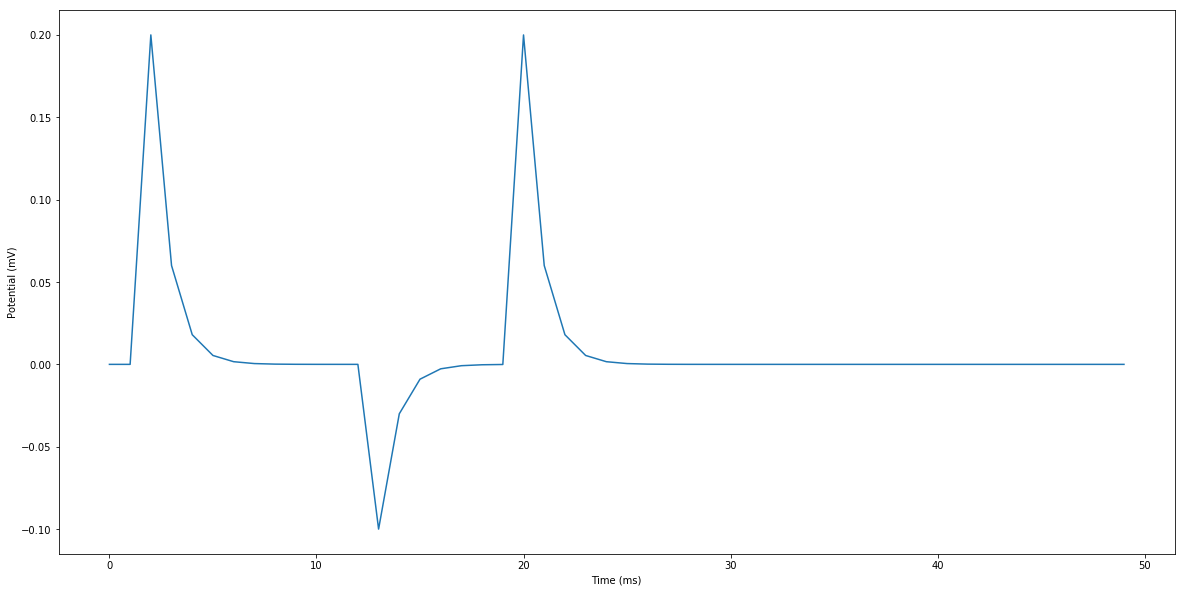

In [39]:
fig = snn2.plot_mem('h',[0])